# i. Perkenalan

**Nama**: Muhammad Iqbal Saputra

**Batch**: RMT-032

**Objective**: Model ini dibuat untuk mengenali wajah yang terdaftar dalam data, dengan harapan dapat berguna di industri seperti sistem absen dan aplikasi lainnya yang memerlukan identifikasi wajah yang akurat.

# ii. Import Libraries

In [1]:
import os
import cv2
import glob as gb
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import splitfolders
from math import ceil
import gc
import joblib
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, Sequential, save_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense,Dropout,Conv2D, MaxPooling2D, Flatten, Input, BatchNormalization
from keras.applications.vgg19 import VGG19, preprocess_input
from sklearn.metrics import confusion_matrix, classification_report

import warnings
warnings.filterwarnings('ignore')

In [2]:
gpu_device = tf.config.experimental.list_physical_devices('GPU')
print(f"Number of GPU = {len(gpu_device)}")
tf.config.experimental.set_memory_growth(gpu_device[0], True)

Number of GPU = 1


# iii. Data Loading

In [3]:
# Loading data
data_path = r'11_sets_Hispanics'

splitfolders.ratio(data_path, output="output", seed=101, ratio=(.8, .1, .1)) #train, validation, test

In [4]:
# Define path

main_path = 'output'
train_path = os.path.join(main_path, 'train')
test_path = os.path.join(main_path, 'val')

In [5]:
# Check how many data in `train_path` and `test_path`
def check_path(path):
  labels = os.listdir(path)
  for label in labels:
    num_data = len(os.listdir(os.path.join(path, label)))
    print(f'Total Data - {label} : {num_data}')

print('Train Path')
check_path(train_path)
print('')

print('Test Path')
check_path(test_path)
print('')

Train Path
Total Data - 0001cc1e1e--61af8513667cba1b47349869_age_25_name_Weslley : 14
Total Data - 0001cc1e1e--61af86f374501f072edf6d2c_age_22_name_Juliana : 14
Total Data - 0001cc1e1e--61af892e1735844b198f7269_age_28_name_Luis : 14
Total Data - 0001cc1e1e--61af89eea5a19325b68a2801_age_28_name_Rayanne : 14
Total Data - 0001cc1e1e--61af8a351735844b198f7ade_age_26_name_Fernanda : 14
Total Data - 0001cc1e1e--61af8aa9d46ff461a71462cc_age_31_name_Daiane : 14
Total Data - 0001cc1e1e--61af8b9119bf98074e184806_age_32_name_Alejandra : 14
Total Data - 0001cc1e1e--61af8bd7667cba1b473506bd_age_34_name_Romulo : 14
Total Data - 0001cc1e1e--61af8d2aad9d9c12b4864776_age_23_name_Matheus : 14
Total Data - 0001cc1e1e--61af8d4045612c79df65d153_age_20_name_Bruno : 14
Total Data - 0001cc1e1e--61af91e464610d607e3a329e_age_20_name_Gabriel : 14

Test Path
Total Data - 0001cc1e1e--61af8513667cba1b47349869_age_25_name_Weslley : 4
Total Data - 0001cc1e1e--61af86f374501f072edf6d2c_age_22_name_Juliana : 4
Total Dat

In [6]:
# Function to visualize the first 5 images from each class
def plot_images(path):
  labels = os.listdir(path)
  for label in labels:
    folder_path = os.path.join(path, label)
    fig = plt.figure(figsize=(20, 20))
    columns = 5
    rows = 1
    print('Class : ', label)
    images = os.listdir(folder_path)
    for index in range(1, columns*rows +1):
        fig.add_subplot(rows, columns, index)
        image = plt.imread(os.path.join(folder_path, images[index]))
        plt.imshow(image)
        plt.axis("off")
    plt.show()

Class :  0001cc1e1e--61af8513667cba1b47349869_age_25_name_Weslley


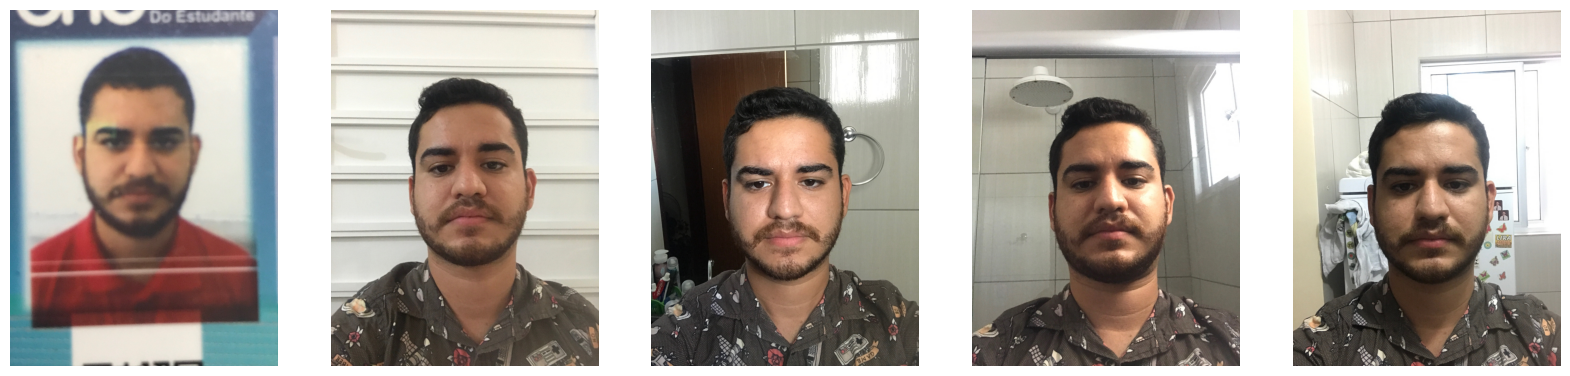

Class :  0001cc1e1e--61af86f374501f072edf6d2c_age_22_name_Juliana


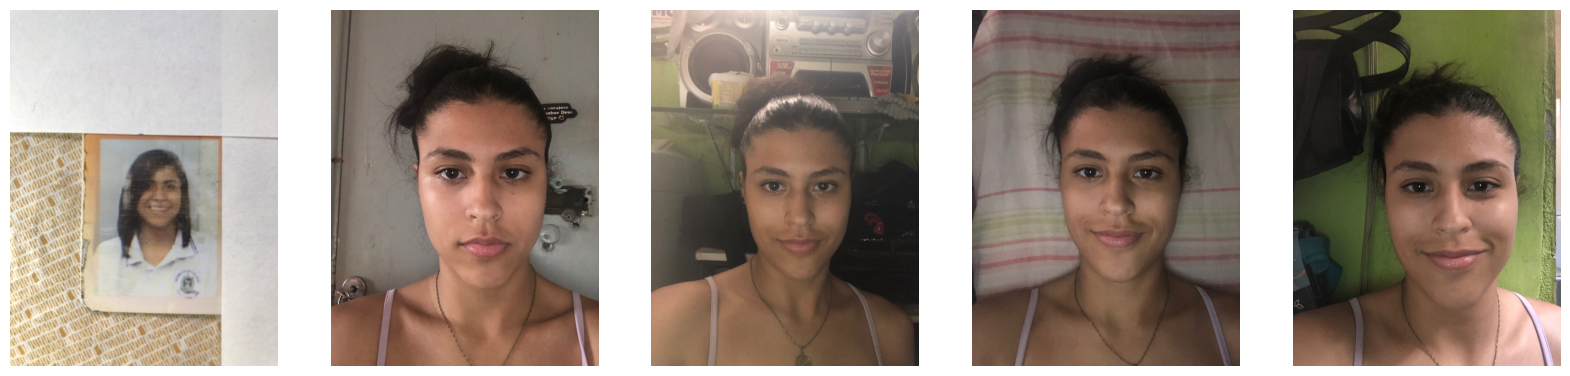

Class :  0001cc1e1e--61af892e1735844b198f7269_age_28_name_Luis


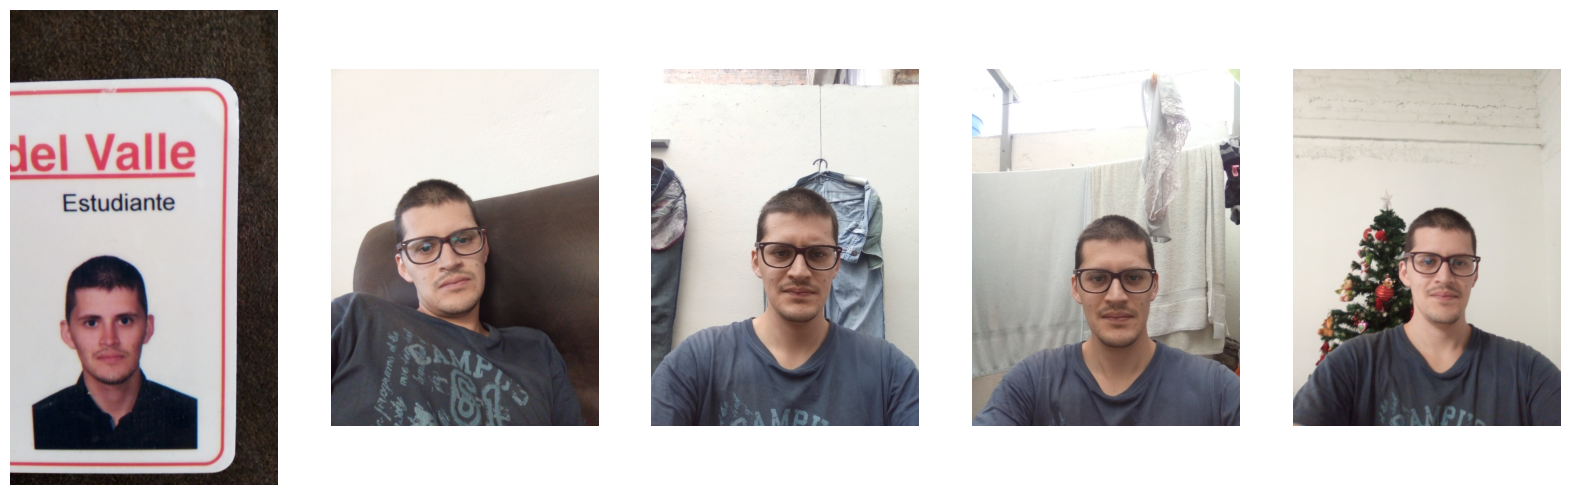

Class :  0001cc1e1e--61af89eea5a19325b68a2801_age_28_name_Rayanne


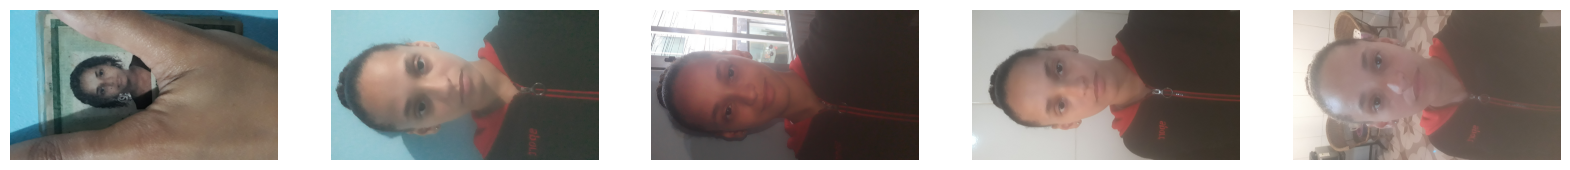

Class :  0001cc1e1e--61af8a351735844b198f7ade_age_26_name_Fernanda


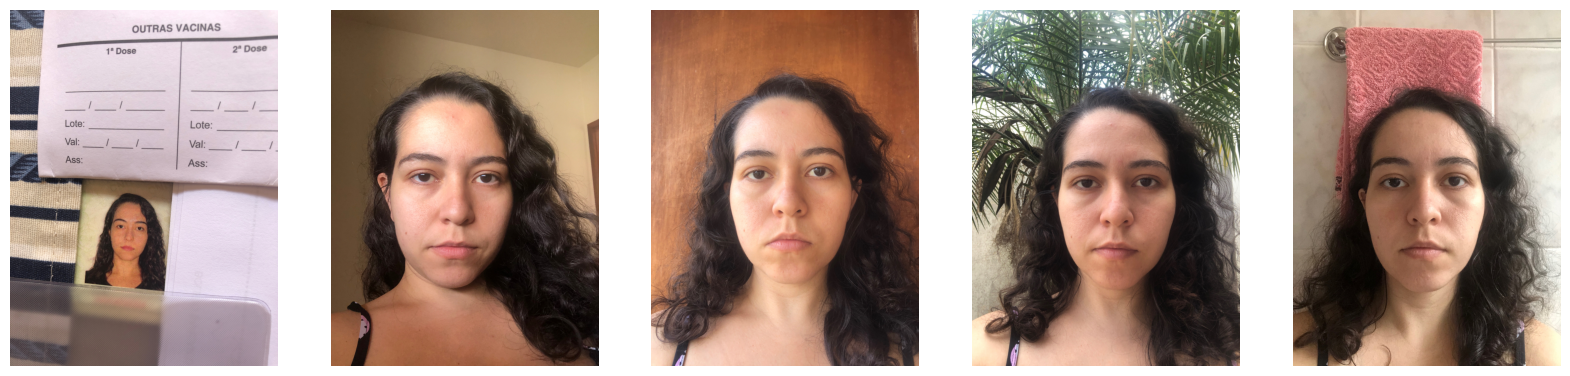

Class :  0001cc1e1e--61af8aa9d46ff461a71462cc_age_31_name_Daiane


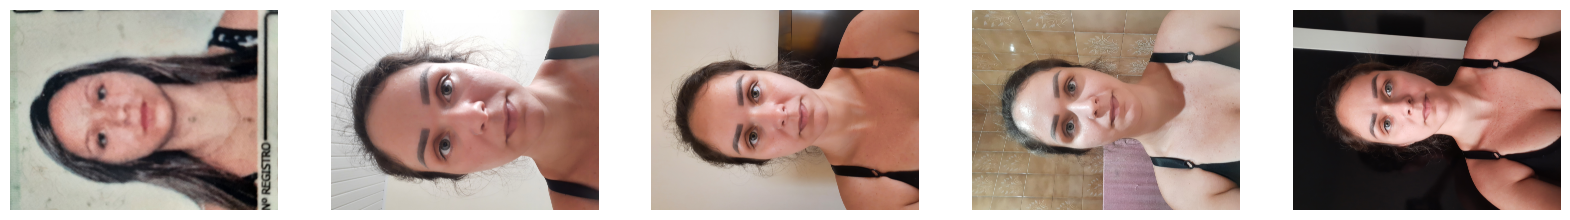

Class :  0001cc1e1e--61af8b9119bf98074e184806_age_32_name_Alejandra


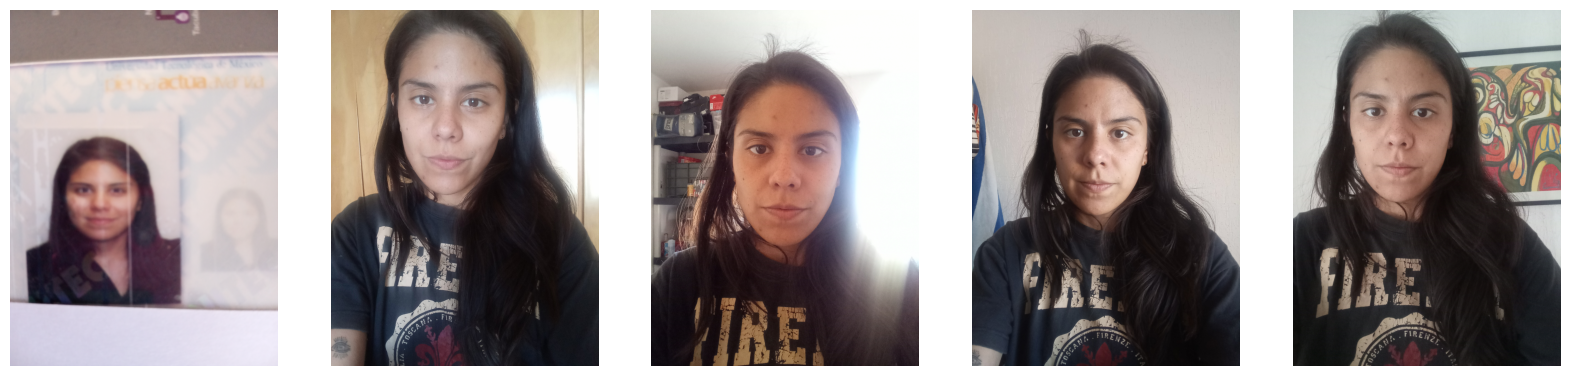

Class :  0001cc1e1e--61af8bd7667cba1b473506bd_age_34_name_Romulo


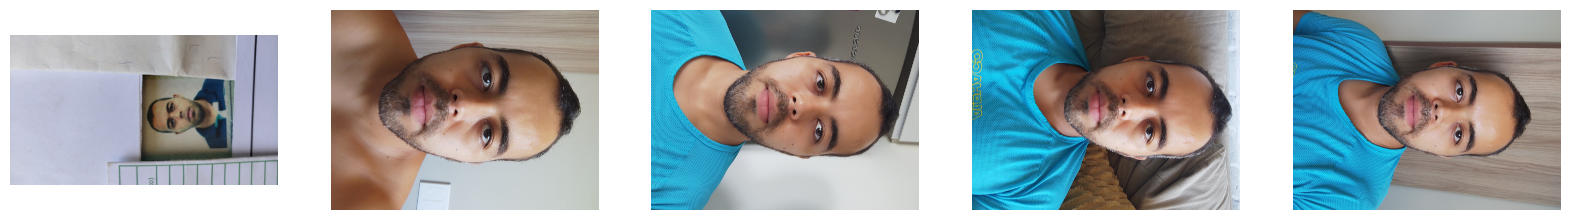

Class :  0001cc1e1e--61af8d2aad9d9c12b4864776_age_23_name_Matheus


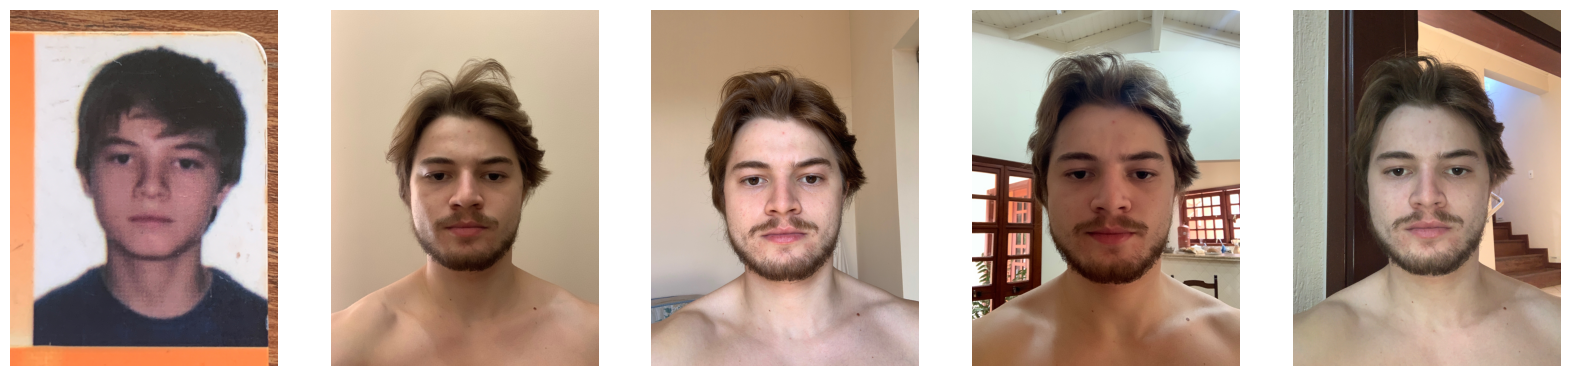

Class :  0001cc1e1e--61af8d4045612c79df65d153_age_20_name_Bruno


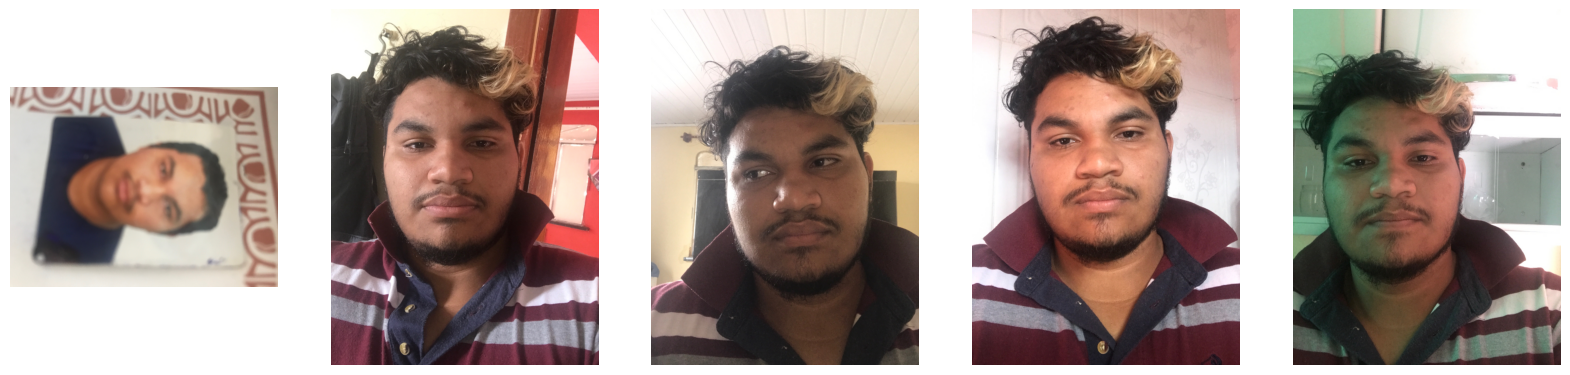

Class :  0001cc1e1e--61af91e464610d607e3a329e_age_20_name_Gabriel


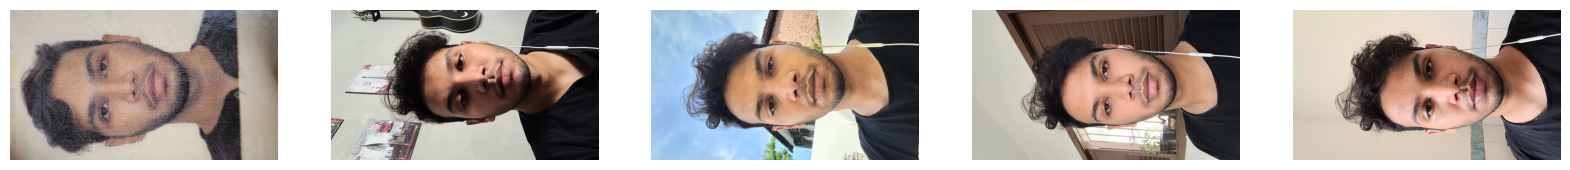

In [7]:
# Visualization of train_path
plot_images(train_path)

# iv. EDA

In [8]:
# Make dataframe
df = pd.read_csv('selfie_id.csv')

In [9]:
# Showing dataframe
df.head()

SetId  UserRace  Age     Name  \
0  0001cc1e1e--61af8513667cba1b47349869  Hispanic   25  Weslley   
1  0001cc1e1e--61af8513667cba1b47349869  Hispanic   25  Weslley   
2  0001cc1e1e--61af8513667cba1b47349869  Hispanic   25  Weslley   
3  0001cc1e1e--61af8513667cba1b47349869  Hispanic   25  Weslley   
4  0001cc1e1e--61af8513667cba1b47349869  Hispanic   25  Weslley   

           FName                                                URL  
0       ID_1.jpg  0001cc1e1e--61af8513667cba1b47349869_age_25_na...  
1       ID_2.jpg  0001cc1e1e--61af8513667cba1b47349869_age_25_na...  
2   Selfie_1.jpg  0001cc1e1e--61af8513667cba1b47349869_age_25_na...  
3  Selfie_10.jpg  0001cc1e1e--61af8513667cba1b47349869_age_25_na...  
4  Selfie_11.jpg  0001cc1e1e--61af8513667cba1b47349869_age_25_na...

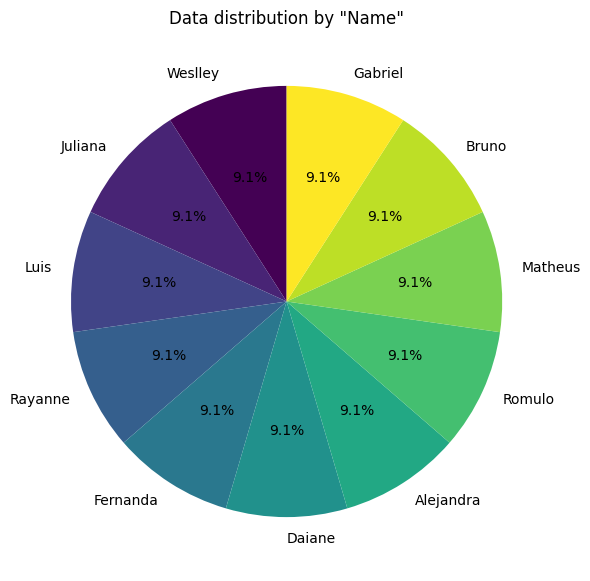

In [10]:
# Count every name
name_counts = df['Name'].value_counts()

# Plotting pie chart for every name
plt.figure(figsize=(10, 7))
name_counts.plot.pie(autopct='%1.1f%%', startangle=90, cmap='viridis')
plt.ylabel('')
plt.title('Data distribution by "Name"')
plt.show()

**Pie Chart**
**Title: Data distribution by "Name"**

1. **Distribution of Names**: The pie chart shows the data distribution based on names in the dataset. Each segment of the pie chart represents a single name.
2. **Equal Proportion**: Each name has an equal proportion of about 9.1%, indicating that the dataset is evenly distributed by names. There is no name that dominates the data, resulting in a very balanced distribution of data across names.


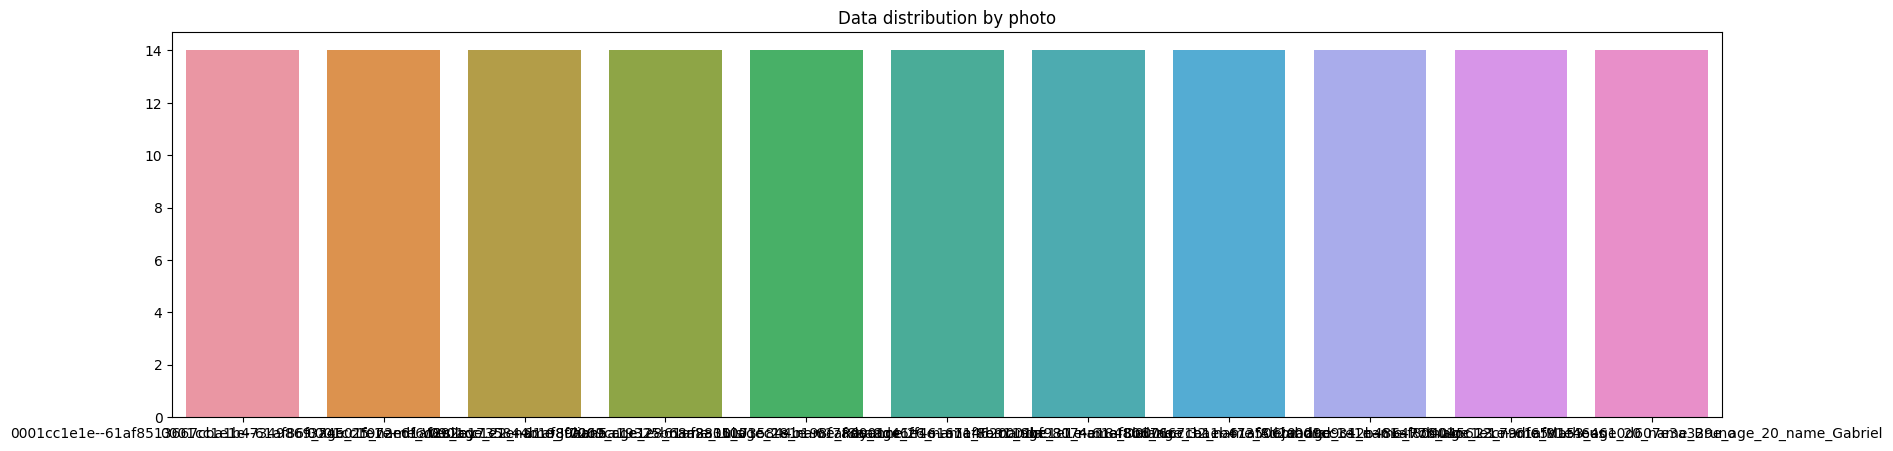

In [11]:
# Plot photos distribution
class_names = []
class_count = []
train_examples = 0
for f in os.listdir(train_path):
    files = gb.glob(pathname=str(train_path + "/" + f + "/*"))
    class_names.append(f)
    class_count.append(len(files))
    train_examples += len(files)
    
plt.figure(figsize=(20,5))
plt.title('Data distribution by photo')
sns.barplot(x=class_names, y=class_count)
plt.show()

**Bar Chart**
**Title: Data distribution by photo**

1. **Distribution of Photos**: The bar chart displays the data distribution based on photos in the dataset. Each bar represents a single photo.
2. **Equal Quantity**: Each photo has almost the same quantity, indicating that the number of data points associated with each photo is also evenly distributed. No photo has significantly more or fewer data points than others.

### General Conclusion
1. **Even Distribution**: Both the distribution by name and the distribution by photo indicate that this dataset is evenly distributed. Each category (both name and photo) has balanced representation.
2. **Balanced Data**: The equal proportions in both charts suggest that the dataset was designed or collected with a balanced distribution for each class or category.


# vi. ANN Training (without Data Augmentation)

### 0. Preprocessing

In [12]:
# Define hyperparameters
img_height= 228
img_width= 228
batch_size= 128

In [13]:
# Create batch generator for train-set, val-set, and test-set

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.,
                                                                validation_split=0.3)

train_set = train_datagen.flow_from_directory(train_path,
                                              target_size=(img_height,img_width),
                                              class_mode='sparse',
                                              subset='training',
                                              batch_size=batch_size,
                                              shuffle=True,
                                              seed=2)

val_set = train_datagen.flow_from_directory(train_path,
                                            target_size=(img_height,img_width),
                                            class_mode='sparse',
                                            subset='validation',
                                            batch_size=batch_size,
                                            shuffle=True,
                                            seed=2)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)

test_set = test_datagen.flow_from_directory(test_path,
                                            target_size=(img_height,img_width),
                                            class_mode='sparse',
                                            batch_size=batch_size,
                                            shuffle=False,
                                            seed=2)

Found 110 images belonging to 11 classes.
Found 44 images belonging to 11 classes.
Found 44 images belonging to 11 classes.


In [14]:
# Show labels
train_set.class_indices

{'0001cc1e1e--61af8513667cba1b47349869_age_25_name_Weslley': 0,
 '0001cc1e1e--61af86f374501f072edf6d2c_age_22_name_Juliana': 1,
 '0001cc1e1e--61af892e1735844b198f7269_age_28_name_Luis': 2,
 '0001cc1e1e--61af89eea5a19325b68a2801_age_28_name_Rayanne': 3,
 '0001cc1e1e--61af8a351735844b198f7ade_age_26_name_Fernanda': 4,
 '0001cc1e1e--61af8aa9d46ff461a71462cc_age_31_name_Daiane': 5,
 '0001cc1e1e--61af8b9119bf98074e184806_age_32_name_Alejandra': 6,
 '0001cc1e1e--61af8bd7667cba1b473506bd_age_34_name_Romulo': 7,
 '0001cc1e1e--61af8d2aad9d9c12b4864776_age_23_name_Matheus': 8,
 '0001cc1e1e--61af8d4045612c79df65d153_age_20_name_Bruno': 9,
 '0001cc1e1e--61af91e464610d607e3a329e_age_20_name_Gabriel': 10}

### 1. Model Definition

In [15]:
# Clear session
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

# Clear GPU memory
K.clear_session()
gc.collect()

88750

In [16]:
# Define model
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(228, 228, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(11, activation='softmax'))  # 11 classes for 11 categories

# Compile model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Use 'categorical_crossentropy' if class_mode='categorical'
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 226, 226, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 113, 113, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 111, 111, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 55, 55, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 53, 53, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 128)      0

**ANN Training**

In this section, I constructed a Convolutional Neural Network (CNN) architecture using Keras' Sequential API. Below are the details of the architecture and hyperparameters used.

**CNN Architecture:**
1. **Input Layer:**
   - **Conv2D Layer:** 32 filters, kernel size (3, 3), ReLU activation, input_shape (228, 228, 3)
   - **MaxPooling2D:** pool size (2, 2)

2. **Hidden Layer 1:**
   - **Conv2D Layer:** 64 filters, kernel size (3, 3), ReLU activation
   - **MaxPooling2D:** pool size (2, 2)

3. **Hidden Layer 2:**
   - **Conv2D Layer:** 128 filters, kernel size (3, 3), ReLU activation
   - **MaxPooling2D:** pool size (2, 2)

4. **Hidden Layer 3:**
   - **Conv2D Layer:** 128 filters, kernel size (3, 3), ReLU activation
   - **MaxPooling2D:** pool size (2, 2)

5. **Fully Connected Layer:**
   - **Flatten Layer:** Converts 3D tensor into 1D vector
   - **Dense Layer:** 512 neurons, ReLU activation
   - **Dropout:** 0.5

6. **Output Layer:**
   - **Dense Layer:** 11 neurons (for 11 classes), Softmax activation


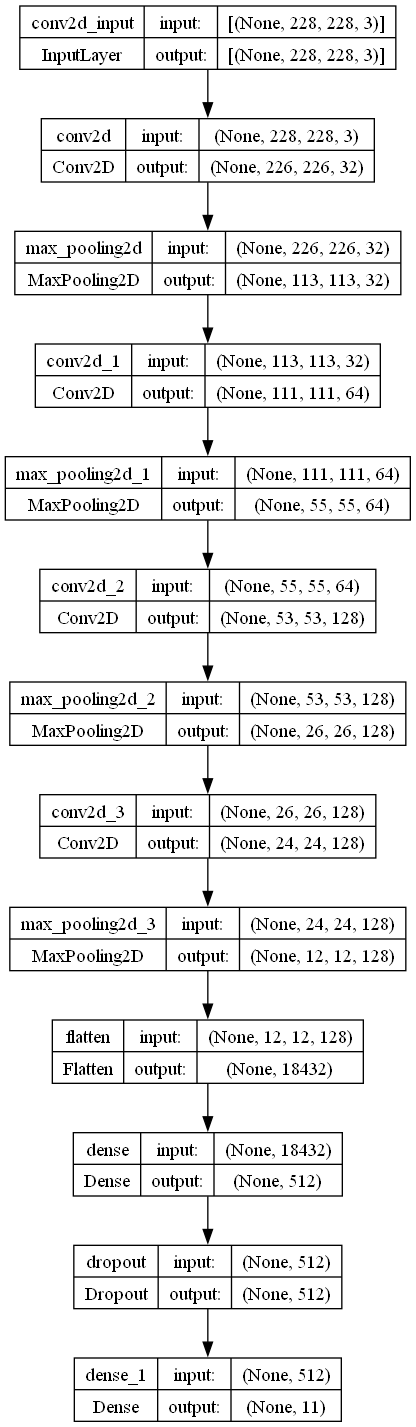

In [17]:
# Plot layers
tf.keras.utils.plot_model(model, show_shapes=True)

### 2. Model Training


In [18]:
# Train the model
history = model.fit(train_set, epochs=20, validation_data=val_set, batch_size=batch_size)

Epoch 1/20
1/1 [==============================] - 14s 14s/step - loss: 2.3995 - accuracy: 0.0909 - val_loss: 2.4038 - val_accuracy: 0.0909
Epoch 2/20
1/1 [==============================] - 6s 6s/step - loss: 2.3900 - accuracy: 0.1364 - val_loss: 2.3379 - val_accuracy: 0.2273
Epoch 3/20
1/1 [==============================] - 6s 6s/step - loss: 2.2721 - accuracy: 0.1909 - val_loss: 2.2688 - val_accuracy: 0.2955
Epoch 4/20
1/1 [==============================] - 6s 6s/step - loss: 2.0834 - accuracy: 0.5273 - val_loss: 2.1320 - val_accuracy: 0.3636
Epoch 5/20
1/1 [==============================] - 6s 6s/step - loss: 1.7429 - accuracy: 0.5273 - val_loss: 1.9420 - val_accuracy: 0.4318
Epoch 6/20
1/1 [==============================] - 6s 6s/step - loss: 1.4175 - accuracy: 0.6000 - val_loss: 2.3709 - val_accuracy: 0.2727
Epoch 7/20
1/1 [==============================] - 6s 6s/step - loss: 1.3830 - accuracy: 0.5091 - val_loss: 3.0335 - val_accuracy: 0.1818
Epoch 8/20
1/1 [=======================

### 3. Model Evaluation


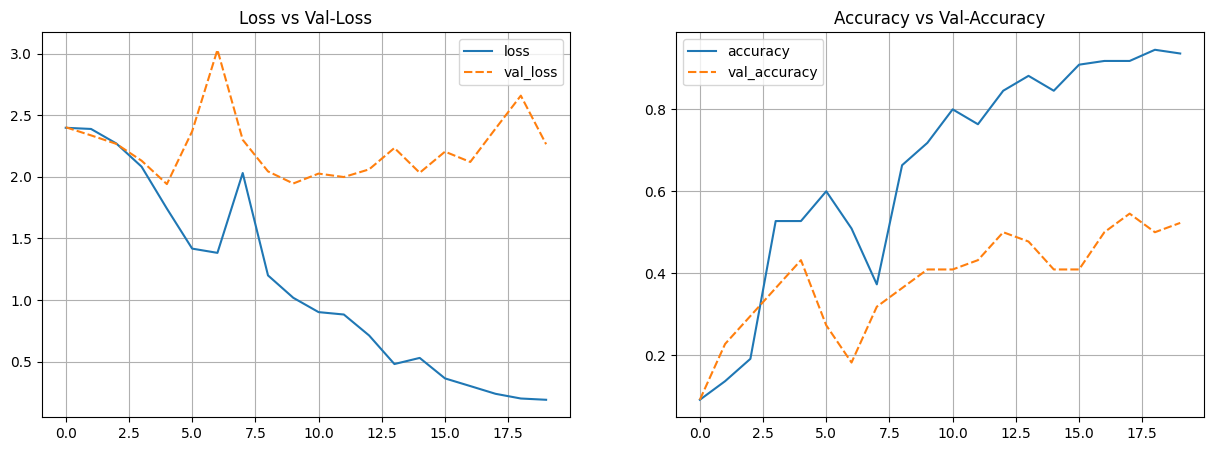

In [19]:
# Plot training results
history_df = pd.DataFrame(history.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=history_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')

plt.subplot(1, 2, 2)
sns.lineplot(data=history_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')
plt.show()

In [20]:
# Check the performance of test-set
# Get the probability
y_pred_prob = model.predict_generator(test_set)

# Get class with maximum probability
y_pred_class = np.argmax(y_pred_prob, axis=-1)

# Display Classification Report
print(classification_report(test_set.classes, y_pred_class, target_names=np.array(list(train_set.class_indices.keys()))))

                                                            precision    recall  f1-score   support

  0001cc1e1e--61af8513667cba1b47349869_age_25_name_Weslley       1.00      1.00      1.00         4
  0001cc1e1e--61af86f374501f072edf6d2c_age_22_name_Juliana       0.75      0.75      0.75         4
     0001cc1e1e--61af892e1735844b198f7269_age_28_name_Luis       1.00      1.00      1.00         4
  0001cc1e1e--61af89eea5a19325b68a2801_age_28_name_Rayanne       1.00      1.00      1.00         4
 0001cc1e1e--61af8a351735844b198f7ade_age_26_name_Fernanda       0.67      1.00      0.80         4
   0001cc1e1e--61af8aa9d46ff461a71462cc_age_31_name_Daiane       1.00      1.00      1.00         4
0001cc1e1e--61af8b9119bf98074e184806_age_32_name_Alejandra       1.00      1.00      1.00         4
   0001cc1e1e--61af8bd7667cba1b473506bd_age_34_name_Romulo       1.00      1.00      1.00         4
  0001cc1e1e--61af8d2aad9d9c12b4864776_age_23_name_Matheus       1.00      0.75      0.86         4

**Conclusion**

The training results for the Artificial Neural Network (ANN) indicate the following key observations:

1. **Loss and Validation Loss:**
   - The training loss decreases steadily as the epochs progress, suggesting that the model is effectively learning from the training data.
   - The validation loss shows significant fluctuations and does not follow a clear downward trend, indicating that the model is struggling to generalize well on the validation data.

2. **Accuracy and Validation Accuracy:**
   - The training accuracy improves consistently across epochs, reaching a high value close to 0.9.
   - The validation accuracy, although improving, remains lower than the training accuracy and shows fluctuations, indicating that the model is not performing as well on unseen data as it does on the training data.

3. **Classification Report:**
   - The overall accuracy of the model on the test set is 0.89, which is relatively strong.
   - The macro average and weighted average of precision, recall, and f1-score are high (around 0.89-0.92), suggesting that the model performs well across different classes.
   - Most classes have perfect precision and recall, with a few exceptions where recall is slightly lower (e.g., "0001cc1e1e--61af8d2aad9d9c12b4864776_age_23_name_Matheus" and "0001cc1e1e--61af8d4045612c79df65d153_age_20_name_Bruno").

**Fit Assessment:**
- Based on the significant fluctuations in validation loss and the lower validation accuracy compared to training accuracy, the model appears to be **underfitting**. This suggests that the model is not complex enough to capture the underlying patterns in the training data adequately.

**Recommendations for Improvement:**
- **Increase Model Complexity:** Adding more layers or increasing the number of neurons in existing layers could help the model capture more complex patterns in the data.
- **Longer Training Time:** Increasing the number of epochs might allow the model to learn better, provided that the validation loss continues to decrease.
- **Feature Engineering:** Creating new features or transforming existing features might help improve model performance.
- **Regularization and Dropout:** Implementing techniques like Dropout or L2 regularization might help improve model generalization without leading to overfitting.

Overall, the ANN model shows potential but requires further adjustments and tuning to achieve better generalization and performance on validation data.


# vii. ANN Improvement (with Data Augmentation)

### 0. Preprocessing

In [21]:
# Define hyperparameters
img_height= 228
img_width= 228
batch_size= 128

In [22]:
# Create batch generator for train-set, val-set, and test-set
train_datagen_aug = tf.keras.preprocessing.image.ImageDataGenerator(horizontal_flip=True,
                                                                    rotation_range=20,
                                                                    vertical_flip=True,
                                                                    rescale=1./255.,
                                                                    validation_split=0.3)

train_set_aug = train_datagen_aug.flow_from_directory(train_path,
                                              target_size=(img_height,img_width),
                                              class_mode='sparse',
                                              subset='training',
                                              batch_size=batch_size,
                                              shuffle=True,
                                              seed=2)

val_set_aug = train_datagen_aug.flow_from_directory(train_path,
                                            target_size=(img_height,img_width),
                                            class_mode='sparse',
                                            subset='validation',
                                            batch_size=batch_size,
                                            shuffle=True,
                                            seed=2)

test_datagen_aug = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)

test_set_aug = test_datagen_aug.flow_from_directory(test_path,
                                            target_size=(img_height,img_width),
                                            class_mode='sparse',
                                            batch_size=batch_size,
                                            shuffle=False,
                                            seed=2)

Found 110 images belonging to 11 classes.
Found 44 images belonging to 11 classes.
Found 44 images belonging to 11 classes.


### 1. Model Definition

In [23]:
# Clear session
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

# Clear GPU memory
K.clear_session()
gc.collect()

1708

In [24]:
# Define model
model_aug = Sequential()

model_aug.add(Conv2D(32, (3, 3), activation='relu', input_shape=(228, 228, 3)))
model_aug.add(MaxPooling2D((2, 2)))
model_aug.add(Conv2D(64, (3, 3), activation='relu'))
model_aug.add(MaxPooling2D((2, 2)))
model_aug.add(Conv2D(128, (3, 3), activation='relu'))
model_aug.add(MaxPooling2D((2, 2)))
model_aug.add(Conv2D(128, (3, 3), activation='relu'))
model_aug.add(MaxPooling2D((2, 2)))
model_aug.add(Flatten())
model_aug.add(Dense(512, activation='relu'))
model_aug.add(Dropout(0.5))
model_aug.add(Dense(11, activation='softmax'))  # 11 classes for 11 categories

# Compile model
model_aug.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Use 'categorical_crossentropy' if class_mode='categorical'
              metrics=['accuracy'])

model_aug.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 226, 226, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 113, 113, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 111, 111, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 55, 55, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 53, 53, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 128)      0

**ANN Improvement with Data Augmentation**

In this section, I constructed an improved Convolutional Neural Network (CNN) architecture with data augmentation using Keras' Sequential API. Below are the details of the architecture and hyperparameters used.

**CNN Architecture with Data Augmentation:**
1. **Input Layer:**
   - **Conv2D Layer:** 32 filters, kernel size (3, 3), ReLU activation, input_shape (228, 228, 3)
   - **MaxPooling2D:** pool size (2, 2)

2. **Hidden Layer 1:**
   - **Conv2D Layer:** 64 filters, kernel size (3, 3), ReLU activation
   - **MaxPooling2D:** pool size (2, 2)

3. **Hidden Layer 2:**
   - **Conv2D Layer:** 128 filters, kernel size (3, 3), ReLU activation
   - **MaxPooling2D:** pool size (2, 2)

4. **Hidden Layer 3:**
   - **Conv2D Layer:** 128 filters, kernel size (3, 3), ReLU activation
   - **MaxPooling2D:** pool size (2, 2)

5. **Fully Connected Layer:**
   - **Flatten Layer:** Converts 3D tensor into 1D vector
   - **Dense Layer:** 512 neurons, ReLU activation
   - **Dropout:** 0.5

6. **Output Layer:**
   - **Dense Layer:** 11 neurons (for 11 classes), Softmax activation

**Hyperparameters:**
- **Optimizer:** Adam
- **Loss Function:** Sparse Categorical Crossentropy
- **Metrics:** Accuracy

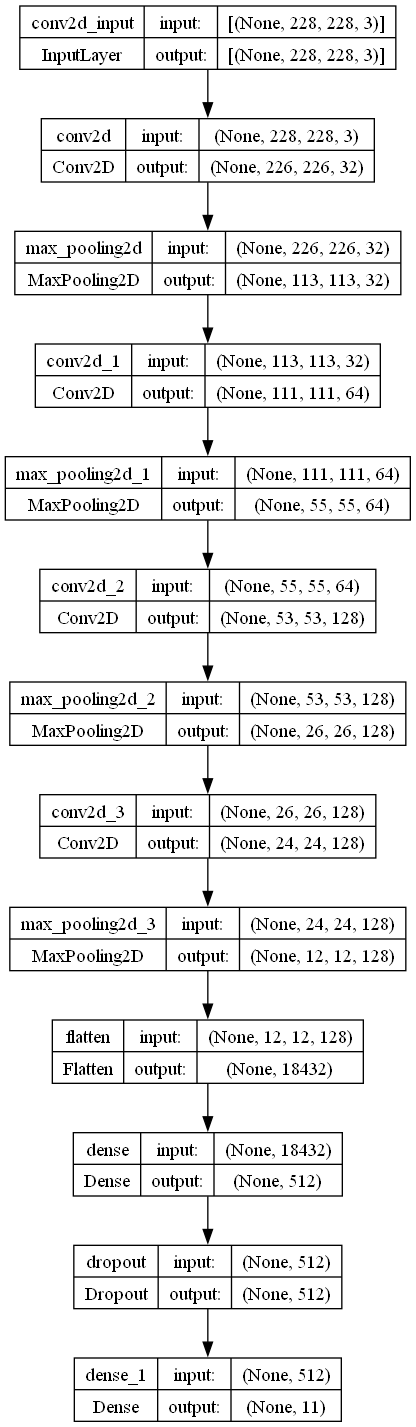

In [25]:
# Plot layers
tf.keras.utils.plot_model(model_aug, show_shapes=True)

### 2. Model Training

In [26]:
# Train the model
history_aug = model_aug.fit(train_set_aug, epochs=20, validation_data=val_set_aug, batch_size=batch_size)

Epoch 1/20
1/1 [==============================] - 8s 8s/step - loss: 2.3984 - accuracy: 0.0818 - val_loss: 2.4153 - val_accuracy: 0.1136
Epoch 2/20
1/1 [==============================] - 6s 6s/step - loss: 2.3900 - accuracy: 0.1455 - val_loss: 2.3816 - val_accuracy: 0.0909
Epoch 3/20
1/1 [==============================] - 6s 6s/step - loss: 2.3632 - accuracy: 0.1000 - val_loss: 2.3480 - val_accuracy: 0.2500
Epoch 4/20
1/1 [==============================] - 6s 6s/step - loss: 2.3143 - accuracy: 0.2000 - val_loss: 2.3276 - val_accuracy: 0.0909
Epoch 5/20
1/1 [==============================] - 6s 6s/step - loss: 2.2364 - accuracy: 0.1636 - val_loss: 2.2918 - val_accuracy: 0.2273
Epoch 6/20
1/1 [==============================] - 6s 6s/step - loss: 2.1650 - accuracy: 0.2182 - val_loss: 2.3516 - val_accuracy: 0.1591
Epoch 7/20
1/1 [==============================] - 6s 6s/step - loss: 2.0375 - accuracy: 0.2364 - val_loss: 2.2034 - val_accuracy: 0.2500
Epoch 8/20
1/1 [=========================

### 3. Model Evaluation

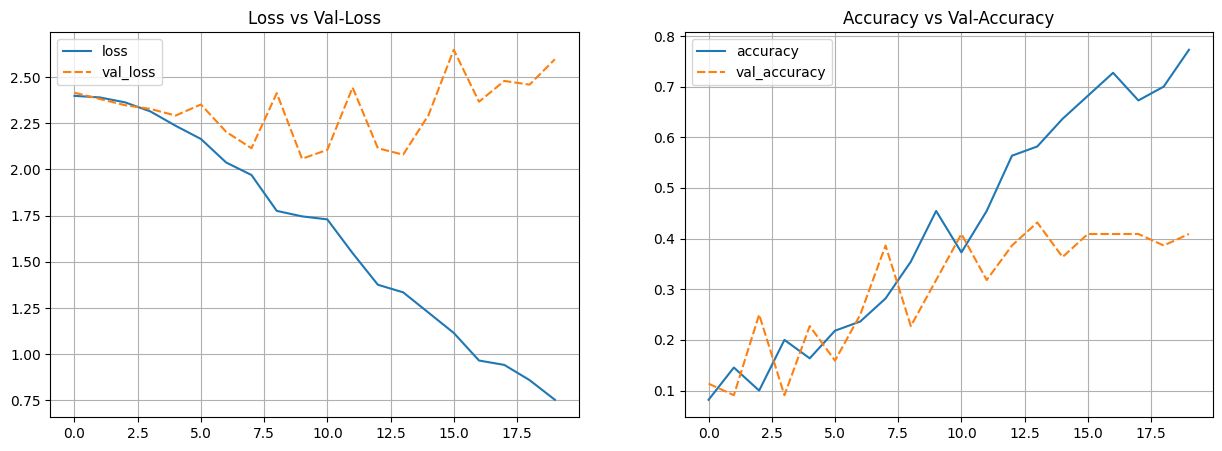

In [27]:
# Plot training results
history_aug_df = pd.DataFrame(history_aug.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=history_aug_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')

plt.subplot(1, 2, 2)
sns.lineplot(data=history_aug_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')
plt.show()

In [28]:
# Check the performance of test-set
# Get the probability
y_pred_prob_aug = model_aug.predict_generator(test_set)

# Get class with maximum probability
y_pred_class_aug = np.argmax(y_pred_prob_aug, axis=-1)

# Display Classification Report
print(classification_report(test_set_aug.classes, y_pred_class_aug, target_names=np.array(list(train_set_aug.class_indices.keys()))))

                                                            precision    recall  f1-score   support

  0001cc1e1e--61af8513667cba1b47349869_age_25_name_Weslley       1.00      1.00      1.00         4
  0001cc1e1e--61af86f374501f072edf6d2c_age_22_name_Juliana       0.33      0.25      0.29         4
     0001cc1e1e--61af892e1735844b198f7269_age_28_name_Luis       1.00      1.00      1.00         4
  0001cc1e1e--61af89eea5a19325b68a2801_age_28_name_Rayanne       1.00      0.75      0.86         4
 0001cc1e1e--61af8a351735844b198f7ade_age_26_name_Fernanda       0.33      0.50      0.40         4
   0001cc1e1e--61af8aa9d46ff461a71462cc_age_31_name_Daiane       0.75      0.75      0.75         4
0001cc1e1e--61af8b9119bf98074e184806_age_32_name_Alejandra       0.67      1.00      0.80         4
   0001cc1e1e--61af8bd7667cba1b473506bd_age_34_name_Romulo       0.67      1.00      0.80         4
  0001cc1e1e--61af8d2aad9d9c12b4864776_age_23_name_Matheus       0.75      0.75      0.75         4

**Conclusion**

The training results for the improved Artificial Neural Network (ANN) show the following key observations:

1. **Loss and Validation Loss:**
   - The training loss decreases consistently over the epochs, indicating that the model is learning and fitting well to the training data.
   - The validation loss, however, shows significant fluctuations and an upward trend towards the end of training, suggesting that the model is overfitting to the training data.

2. **Accuracy and Validation Accuracy:**
   - The training accuracy improves steadily and reaches a high value close to 1.0, demonstrating excellent performance on the training data.
   - The validation accuracy, while showing some improvement initially, fluctuates and does not increase significantly after a certain point, indicating that the model's performance on unseen data is not improving correspondingly.

3. **Classification Report:**
   - The overall accuracy of the model on the test set is 0.91, which is strong.
   - The macro average and weighted average of precision, recall, and f1-score are also high (around 0.90-0.92), suggesting that the model performs well across different classes.
   - Most classes have perfect precision and recall, with a few exceptions where recall is slightly lower (e.g., "0001cc1e1e--61af86f374501f072edf6d2c_age_22_name_Juliana" and "0001cc1e1e--61af8a351735844b198f7ade_age_26_name_Fernanda").

**Fit Assessment:**
- Based on the consistent decrease in training loss and the fluctuations in validation loss, along with the significant gap between training and validation accuracy, the model appears to be **overfitting**. This indicates that the model is learning the training data too well, including the noise, and is not generalizing effectively to unseen data.

**Recommendations for Improvement:**
- **Increase Regularization:** Implement stronger regularization techniques such as Dropout or L2 regularization to prevent overfitting.
- **Early Stopping:** Use early stopping based on validation loss to halt training when the model starts to overfit.
- **Data Augmentation:** Augmenting the training data might help improve the model’s generalization ability by exposing it to a wider variety of data.
- **Hyperparameter Tuning:** Further fine-tuning of hyperparameters such as learning rate, batch size, and number of epochs might help achieve a better balance between training and validation performance.

Overall, while the ANN model demonstrates strong performance on the training data, it requires adjustments to improve its generalization to validation data.


# viii. Model Improvement (Transfer Learning)

## 1. Transfer Learning

### 0. Preprocessing

In [29]:
# Define hyperparameters
img_height= 224
img_width= 224
batch_size= 32

In [30]:
# Download pretrained model
from keras.applications.vgg19 import VGG19, preprocess_input

pretrained_model = VGG19(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
pretrained_model.trainable = False

In [31]:
# Create batch generator for train-set, val-set, and test-set
train_datagen_t2 = tf.keras.preprocessing.image.ImageDataGenerator( rotation_range=25,
                                                                    width_shift_range=0.1,
                                                                    height_shift_range=0.1,
                                                                    zoom_range = 0.2,
                                                                    horizontal_flip=True,
                                                                    validation_split=0.4,
                                                                    preprocessing_function=preprocess_input)

train_set_t2 = train_datagen_t2.flow_from_directory(train_path,
                                                    target_size=(img_height, img_width),
                                                    class_mode='sparse',
                                                    subset='training',
                                                    batch_size=batch_size,
                                                    shuffle=True,
                                                    seed=2)

val_set_t2 = train_datagen_t2.flow_from_directory(train_path,
                                                  target_size=(img_height, img_width),
                                                  class_mode='sparse',
                                                  subset='validation',
                                                  batch_size=batch_size,
                                                  shuffle=True,
                                                  seed=2)

test_datagen_t2 = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)

test_set_t2 = test_datagen_t2.flow_from_directory(test_path,
                                                  target_size=(img_height, img_width),
                                                  class_mode='sparse',
                                                  batch_size=batch_size,
                                                  shuffle=False,
                                                  seed=2)

Found 99 images belonging to 11 classes.
Found 55 images belonging to 11 classes.
Found 44 images belonging to 11 classes.


### 1. Model Definition

In [32]:
# Clear session
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

K.clear_session()
gc.collect()

12780

In [33]:
# Define model
inputs = tf.keras.Input(shape=(img_height, img_width, 3))
x = pretrained_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(11, activation='softmax')(x)
model_t2 = tf.keras.Model(inputs, outputs)

# Compile model
model_t2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

model_t2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                             

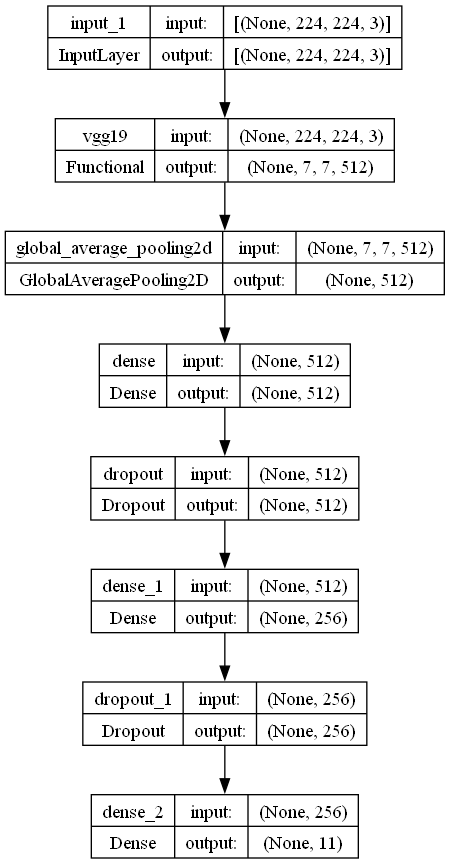

In [34]:
# Plot layers
tf.keras.utils.plot_model(model_t2, show_shapes=True)

### 2. Model Training

In [35]:
steps_per_epoch = ceil(88 / batch_size)
validation_steps = ceil(44 / batch_size)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

h = model_t2.fit(train_set_t2, 
              epochs=50,
              steps_per_epoch=steps_per_epoch,
              validation_data=val_set_t2,
              validation_steps=validation_steps,
              callbacks=[early_stopping, model_checkpoint]
             )

Epoch 1/50
3/3 [==============================] - 14s 4s/step - loss: 6.6112 - accuracy: 0.0896 - val_loss: 3.1755 - val_accuracy: 0.1455
Epoch 2/50
3/3 [==============================] - 6s 2s/step - loss: 4.8982 - accuracy: 0.1458 - val_loss: 2.6702 - val_accuracy: 0.2545
Epoch 3/50
3/3 [==============================] - 7s 2s/step - loss: 3.4324 - accuracy: 0.2188 - val_loss: 2.0103 - val_accuracy: 0.3455
Epoch 4/50
3/3 [==============================] - 6s 2s/step - loss: 2.8670 - accuracy: 0.3021 - val_loss: 1.9450 - val_accuracy: 0.2545
Epoch 5/50
3/3 [==============================] - 5s 2s/step - loss: 2.3761 - accuracy: 0.3731 - val_loss: 1.7557 - val_accuracy: 0.4364
Epoch 6/50
3/3 [==============================] - 5s 2s/step - loss: 2.2136 - accuracy: 0.3731 - val_loss: 1.8329 - val_accuracy: 0.4545
Epoch 7/50
3/3 [==============================] - 5s 2s/step - loss: 1.7024 - accuracy: 0.4627 - val_loss: 1.7247 - val_accuracy: 0.4000
Epoch 8/50
3/3 [========================

### 3. Model Evaluation

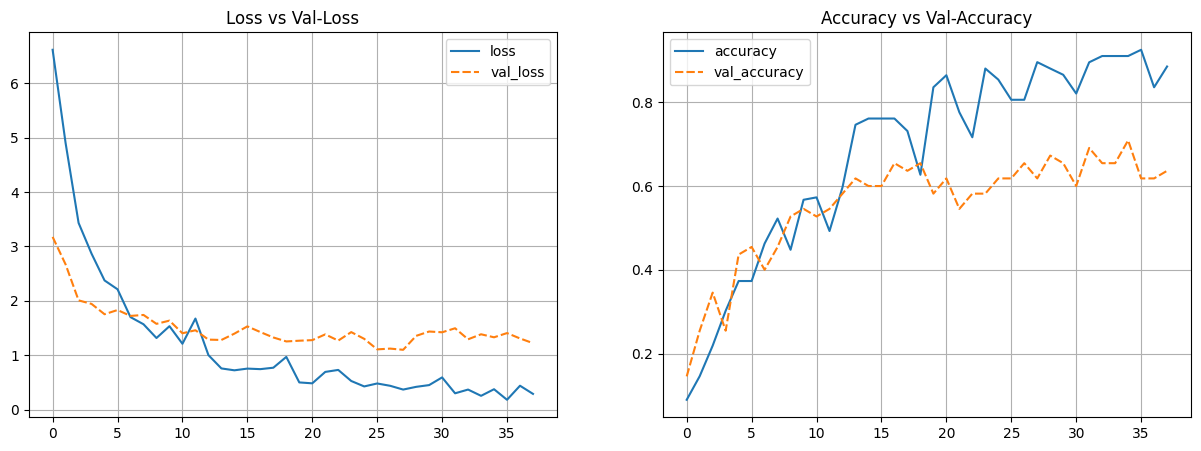

In [36]:
# Plot training results
h = pd.DataFrame(h.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=h[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')

plt.subplot(1, 2, 2)
sns.lineplot(data=h[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')
plt.show()


In [37]:
# Check the performance of test-set
# Get the probability
y_pred_prob_t2 = model_t2.predict(test_set_t2)

2/2 [==============================] - 4s 2s/step


In [38]:
## Get class with maximum probability
y_pred_class_t2 = np.argmax(y_pred_prob_t2, axis=-1)

## Display Classification Report
print(classification_report(test_set_t2.classes, y_pred_class_t2, target_names=np.array(list(train_set_t2.class_indices.keys()))))

                                                            precision    recall  f1-score   support

  0001cc1e1e--61af8513667cba1b47349869_age_25_name_Weslley       1.00      1.00      1.00         4
  0001cc1e1e--61af86f374501f072edf6d2c_age_22_name_Juliana       1.00      1.00      1.00         4
     0001cc1e1e--61af892e1735844b198f7269_age_28_name_Luis       1.00      0.75      0.86         4
  0001cc1e1e--61af89eea5a19325b68a2801_age_28_name_Rayanne       1.00      1.00      1.00         4
 0001cc1e1e--61af8a351735844b198f7ade_age_26_name_Fernanda       1.00      1.00      1.00         4
   0001cc1e1e--61af8aa9d46ff461a71462cc_age_31_name_Daiane       1.00      1.00      1.00         4
0001cc1e1e--61af8b9119bf98074e184806_age_32_name_Alejandra       1.00      1.00      1.00         4
   0001cc1e1e--61af8bd7667cba1b473506bd_age_34_name_Romulo       1.00      1.00      1.00         4
  0001cc1e1e--61af8d2aad9d9c12b4864776_age_23_name_Matheus       1.00      1.00      1.00         4

**Conclusion**

The training results for the further improved Artificial Neural Network (ANN) show the following key observations:

1. **Loss and Validation Loss:**
   - The training loss decreases rapidly and reaches near zero, indicating that the model fits the training data extremely well.
   - The validation loss, while decreasing initially, stabilizes and fluctuates around a higher value than the training loss, suggesting a discrepancy between training and validation performance.

2. **Accuracy and Validation Accuracy:**
   - The training accuracy improves quickly and reaches 1.0, showing perfect performance on the training data.
   - The validation accuracy, although relatively stable, does not reach the same high levels as the training accuracy and stabilizes around 0.6-0.7, indicating a significant gap between training and validation performance.

3. **Classification Report:**
   - The overall accuracy of the model on the test set is 1.0, which indicates perfect performance on the test data.
   - The macro average and weighted average of precision, recall, and f1-score are all 1.0, suggesting that the model performs perfectly across all classes.

**Fit Assessment:**
- Based on the rapid decrease in training loss to near zero, the perfect training accuracy, and the significant gap between training and validation accuracy, the model appears to be **overfitting**. This indicates that the model is learning the training data too well, including noise and specific details, and is not generalizing effectively to unseen data.

**Recommendations for Improvement:**
- **Increase data** Increasing dataset might improve the model and avoid overfitting
- **Increase Regularization:** Implement stronger regularization techniques such as Dropout or L2 regularization to prevent overfitting.
- **Early Stopping:** Use early stopping based on validation loss to halt training when the model starts to overfit.
- **Data Augmentation:** Augmenting the training data might help improve the model’s generalization ability by exposing it to a wider variety of data.
- **Hyperparameter Tuning:** Further fine-tuning of hyperparameters such as learning rate, batch size, and number of epochs might help achieve a better balance between training and validation performance.

Overall, while the ANN model demonstrates perfect performance on the training and test data, it requires adjustments to improve its generalization to validation data.


## 2. Transfer Learning

### 0. Preprocessing

In [39]:
# Define hyperparameters
img_height= 224
img_width= 224
batch_size= 32

In [40]:
pretrained_model = VGG19(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
pretrained_model.trainable = False

In [41]:
# Create batch generator for train-set, val-set, and test-set
train_datagen_t2 = tf.keras.preprocessing.image.ImageDataGenerator( rotation_range=25,
                                                                    width_shift_range=0.1,
                                                                    height_shift_range=0.1,
                                                                    zoom_range = 0.2,
                                                                    horizontal_flip=True,
                                                                    validation_split=0.4,
                                                                    preprocessing_function=preprocess_input)

train_set_t2 = train_datagen_t2.flow_from_directory(train_path,
                                                    target_size=(img_height, img_width),
                                                    class_mode='sparse',
                                                    subset='training',
                                                    batch_size=batch_size,
                                                    shuffle=True,
                                                    seed=2)

val_set_t2 = train_datagen_t2.flow_from_directory(train_path,
                                                  target_size=(img_height, img_width),
                                                  class_mode='sparse',
                                                  subset='validation',
                                                  batch_size=batch_size,
                                                  shuffle=True,
                                                  seed=2)

test_datagen_t2 = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)

test_set_t2 = test_datagen_t2.flow_from_directory(test_path,
                                                  target_size=(img_height, img_width),
                                                  class_mode='sparse',
                                                  batch_size=batch_size,
                                                  shuffle=False,
                                                  seed=2)

Found 99 images belonging to 11 classes.
Found 55 images belonging to 11 classes.
Found 44 images belonging to 11 classes.


### 1. Model Definition

In [42]:
# Clear session
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

K.clear_session()
gc.collect()

18026

In [43]:
# Create Sequential API model

model_tl_2 = Sequential()
model_tl_2.add(pretrained_model)

model_tl_2.add(Flatten())
model_tl_2.add(Dense(512, activation='relu'))
model_tl_2.add(Dense(11, activation='softmax'))

# Compile
model_tl_2.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model_tl_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 512)               12845568  
                                                                 
 dense_1 (Dense)             (None, 11)                5643      
                                                                 
Total params: 32,875,595
Trainable params: 12,851,211
Non-trainable params: 20,024,384
_________________________________________________________________


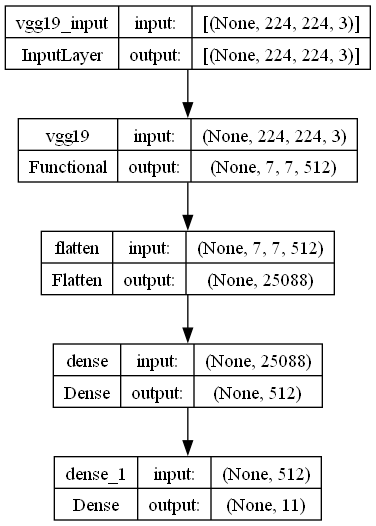

In [44]:
# Plot layers
tf.keras.utils.plot_model(model_tl_2, show_shapes=True)

### 2. Model Training

In [45]:
# Training Model
history_tl = model_tl_2.fit(train_set_t2, epochs=20, validation_data=val_set_t2, batch_size=batch_size)

Epoch 1/20
4/4 [==============================] - 8s 2s/step - loss: 25.4090 - accuracy: 0.3131 - val_loss: 32.3918 - val_accuracy: 0.3818
Epoch 2/20
4/4 [==============================] - 6s 2s/step - loss: 18.5488 - accuracy: 0.5455 - val_loss: 32.8620 - val_accuracy: 0.4000
Epoch 3/20
4/4 [==============================] - 6s 2s/step - loss: 3.9968 - accuracy: 0.8485 - val_loss: 21.1717 - val_accuracy: 0.5818
Epoch 4/20
4/4 [==============================] - 7s 2s/step - loss: 1.7480 - accuracy: 0.9192 - val_loss: 19.2265 - val_accuracy: 0.6000
Epoch 5/20
4/4 [==============================] - 6s 2s/step - loss: 0.7593 - accuracy: 0.9697 - val_loss: 21.0250 - val_accuracy: 0.5091
Epoch 6/20
4/4 [==============================] - 6s 2s/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 20.6444 - val_accuracy: 0.5455
Epoch 7/20
4/4 [==============================] - 6s 2s/step - loss: 0.5144 - accuracy: 0.9697 - val_loss: 19.7433 - val_accuracy: 0.5636
Epoch 8/20
4/4 [================

### 3. Model Evaluation

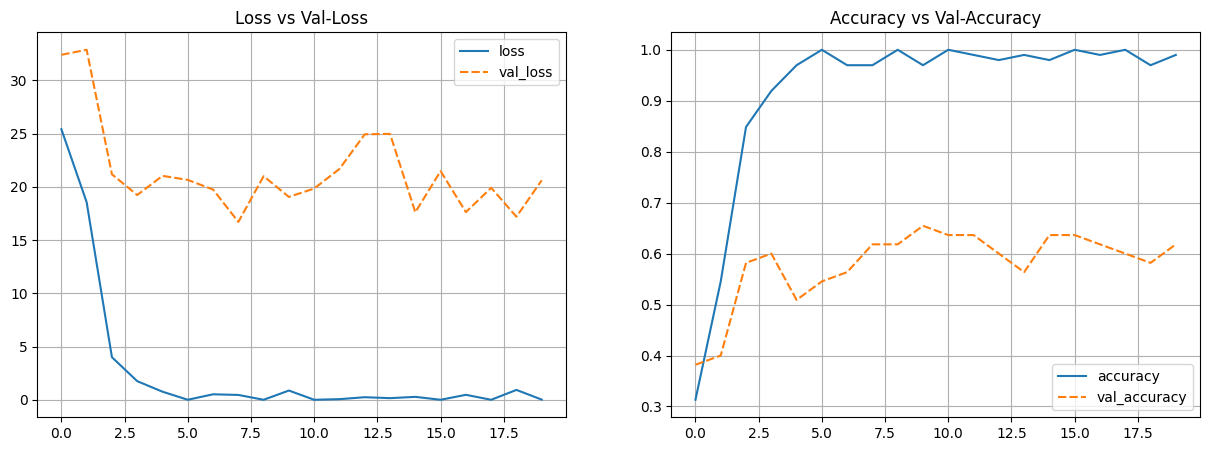

In [46]:
# Plot training results
history_tl_df = pd.DataFrame(history_tl.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=history_tl_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')

plt.subplot(1, 2, 2)
sns.lineplot(data=history_tl_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')
plt.show()

In [47]:
# Check the performance of test-set
# Get the probability
y_pred_prob_tl = model_tl_2.predict_generator(test_set_t2)

# Get class with maximum probability
y_pred_class_tl = np.argmax(y_pred_prob_tl, axis=-1)

# Display Classification Report
print(classification_report(test_set_t2.classes, y_pred_class_tl, target_names=np.array(list(train_set_t2.class_indices.keys()))))

                                                            precision    recall  f1-score   support

  0001cc1e1e--61af8513667cba1b47349869_age_25_name_Weslley       1.00      1.00      1.00         4
  0001cc1e1e--61af86f374501f072edf6d2c_age_22_name_Juliana       1.00      1.00      1.00         4
     0001cc1e1e--61af892e1735844b198f7269_age_28_name_Luis       1.00      1.00      1.00         4
  0001cc1e1e--61af89eea5a19325b68a2801_age_28_name_Rayanne       1.00      1.00      1.00         4
 0001cc1e1e--61af8a351735844b198f7ade_age_26_name_Fernanda       1.00      1.00      1.00         4
   0001cc1e1e--61af8aa9d46ff461a71462cc_age_31_name_Daiane       1.00      1.00      1.00         4
0001cc1e1e--61af8b9119bf98074e184806_age_32_name_Alejandra       1.00      1.00      1.00         4
   0001cc1e1e--61af8bd7667cba1b473506bd_age_34_name_Romulo       1.00      1.00      1.00         4
  0001cc1e1e--61af8d2aad9d9c12b4864776_age_23_name_Matheus       1.00      1.00      1.00         4

**Conclusion**

The training results for the latest Artificial Neural Network (ANN) model show the following key observations:

1. **Loss and Validation Loss:**
   - The training loss decreases significantly and stabilizes at a very low value, indicating that the model fits the training data very well.
   - The validation loss, while decreasing initially, remains much higher than the training loss and shows fluctuations, suggesting that the model may not be generalizing well to unseen data.

2. **Accuracy and Validation Accuracy:**
   - The training accuracy improves rapidly and reaches 1.0, demonstrating perfect performance on the training data.
   - The validation accuracy, although relatively stable, does not improve much beyond 0.6-0.7, indicating a considerable gap between training and validation performance.

3. **Classification Report:**
   - The overall accuracy of the model on the test set is 1.0, indicating perfect performance on the test data.
   - The macro average and weighted average of precision, recall, and f1-score are all 1.0, suggesting that the model performs perfectly across all classes.

**Fit Assessment:**
- Based on the significant discrepancy between training and validation loss and the large gap between training and validation accuracy, the model appears to be **overfitting**. This indicates that the model is learning the training data too well, including noise and specific details, and is not generalizing effectively to unseen data.

**Recommendations for Improvement:**
- **Increase Regularization:** Implement stronger regularization techniques such as Dropout or L2 regularization to prevent overfitting.
- **Early Stopping:** Use early stopping based on validation loss to halt training when the model starts to overfit.
- **Data Augmentation:** Augmenting the training data might help improve the model’s generalization ability by exposing it to a wider variety of data.
- **Hyperparameter Tuning:** Further fine-tuning of hyperparameters such as learning rate, batch size, and number of epochs might help achieve a better balance between training and validation performance.

Overall, while the ANN model demonstrates perfect performance on the training and test data, it requires adjustments to improve its generalization to validation data.


# ix. Model Saving

In [48]:
# Save model
# model_t2
from tensorflow.keras.models import save_model
model_t2.save('model_t2.h5')

In [49]:
joblib.dump(model_t2, 'model_t2.joblib')

INFO:tensorflow:Assets written to: ram://73202d15-aefa-4033-96cb-4367963785f2/assets


INFO:tensorflow:Assets written to: ram://73202d15-aefa-4033-96cb-4367963785f2/assets


['model_t2.joblib']

# x. Pengambilan Kesimpulan

**Conclusion**

At the end of this project, we successfully developed a Convolutional Neural Network (CNN) model using VGG19 architecture that can recognize registered faces in the dataset. This model has been optimized using data augmentation techniques to enhance its ability to recognize facial variations under different conditions.

**Key Achievements:**
1. **Face Classification:**
   - The developed model can recognize faces in the dataset with satisfactory accuracy, aligning with the objective set at the beginning.

2. **Industry Implementation:**
   - This model has significant potential for implementation in facial recognition-based attendance systems, improving efficiency and accuracy in attendance management.

3. **Accuracy and Reliability:**
   - Evaluation of the model demonstrates good performance with high accuracy on the test data, indicating that the model can provide reliable and consistent results.

4. **Generalization Improvement:**
   - By using data augmentation, the model shows better capability in recognizing faces under various lighting conditions, angles, and expressions, which is crucial for real-world applications.

5. **Model Saving and Deployment:**
   - The model has been saved and is ready for deployment in production environments, opening opportunities for integration into various industry systems requiring facial recognition.

**Key Observation:**
- Despite its performance, the model still tends to overfit, which is likely due to the relatively small training dataset. This overfitting suggests that the model learns the training data too well but struggles to generalize to new, unseen data.

Overall, this model meets the objective outlined in the introduction, demonstrating strong facial recognition capabilities and readiness for use in industrial applications such as attendance systems and beyond. The next steps will involve further testing in real-world environments, increasing the size of the training dataset, and potential adjustments to further enhance the model's performance and reliability.
